# Machine Vision Lab 2

## Prereqiusite

In [3]:
# Imports
from PIL import Image, ImageFilter, ImageOps
import cv2 as cv
import matplotlib.pyplot as plt
import numpy as np
import cv2

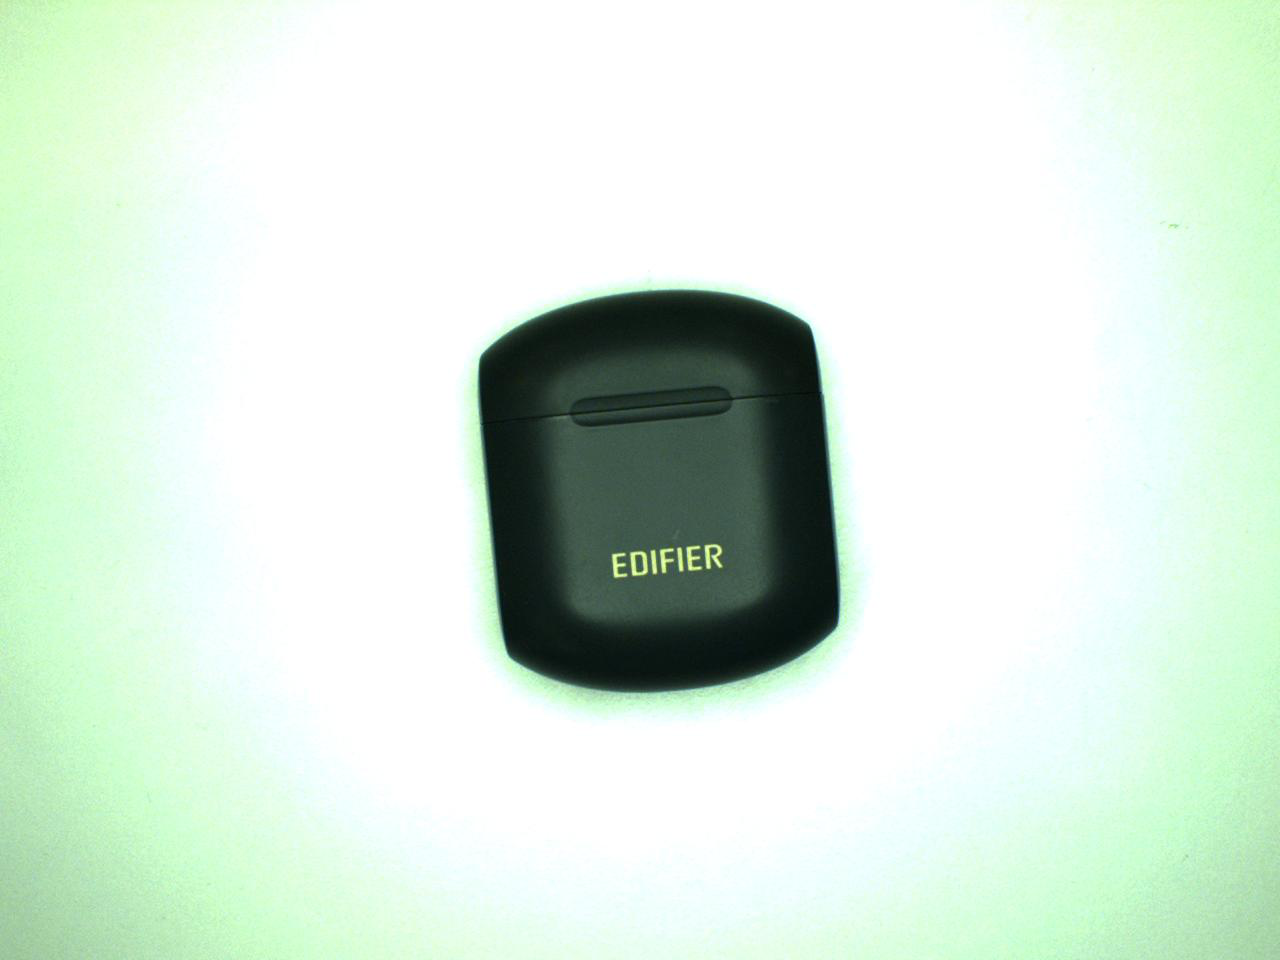

In [4]:
from PIL import Image

filename = 'D:\\UTAR\\Degree\\Y3S1\Machine Vision\\Practical\\Machine_Vision_Github\\Lab 2_Assets\\Earphone.jpg'


with Image.open(filename) as img:
    img.load()

# img.format ##  format = PNG
# img.size ## size = (1280, 960)
# img.mode ## mode = RGB

display(img)

## Image Thresholding

### 1. Crop Image

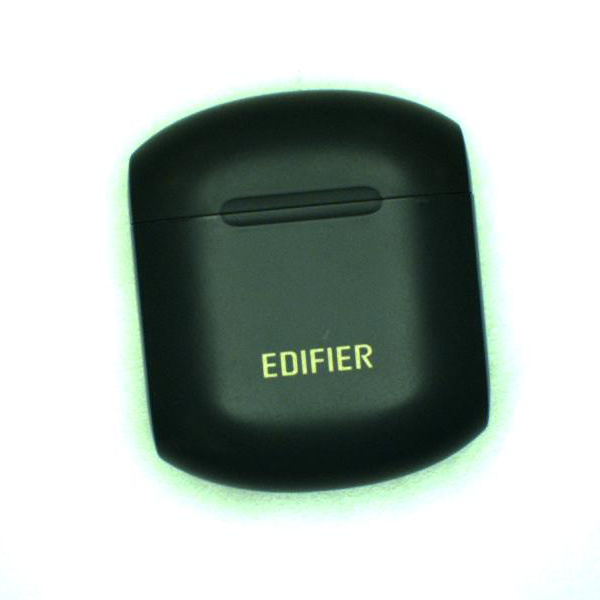

In [5]:
cropped_img = img.crop((350, 200, 950, 800)) 

# has 4 tuples defines left, upper, right, bottom
# Pillow assigns the coordinates (0,0) to the pixel at the upper-left corner

cropped_img.size 
(600, 600)
# the new image cropped has a size of 350 x 950 pixels

display(cropped_img)

### 2. Convert to Grayscale Image

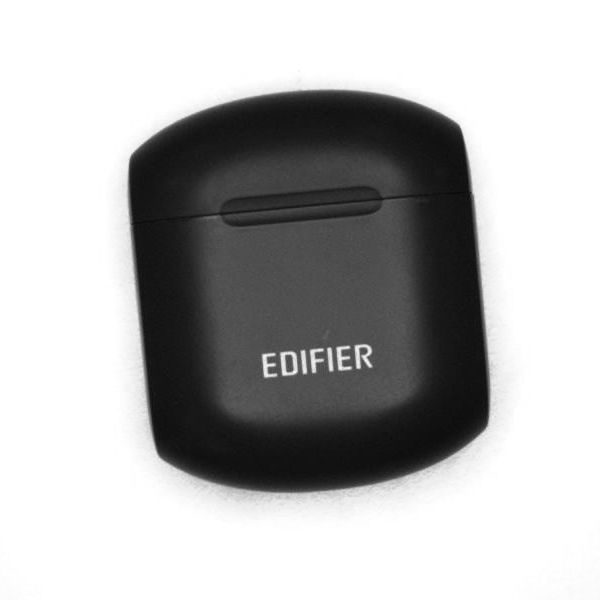

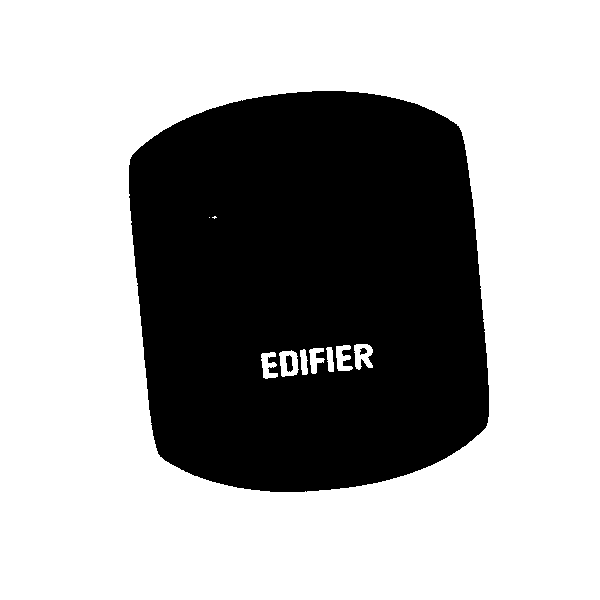

In [6]:
img_in_gray = cropped_img.convert("L")
display (img_in_gray) 

threshold = 98
# A pixel value greater than 80 are converted to white, and all other pixels are changed to black

threshold_img = img_in_gray.point(lambda x: 255 if x > threshold else 0)
display (threshold_img)

### 3. Image Thresholding

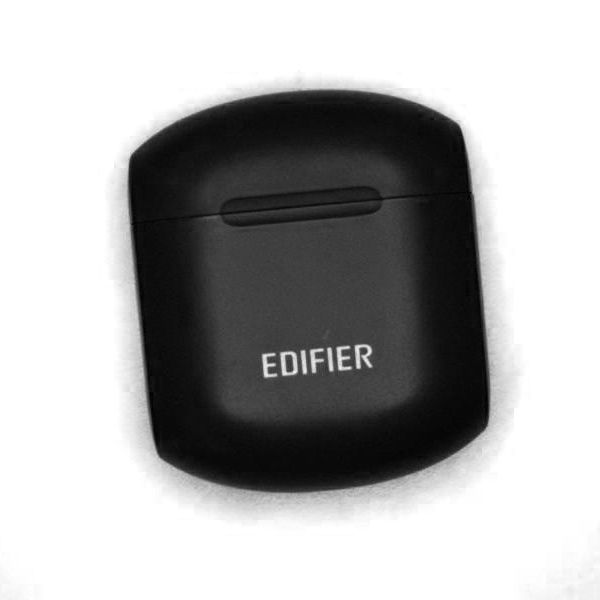

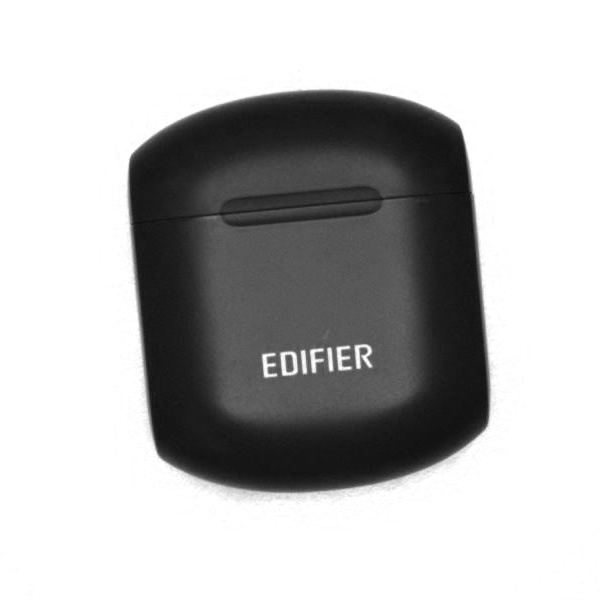

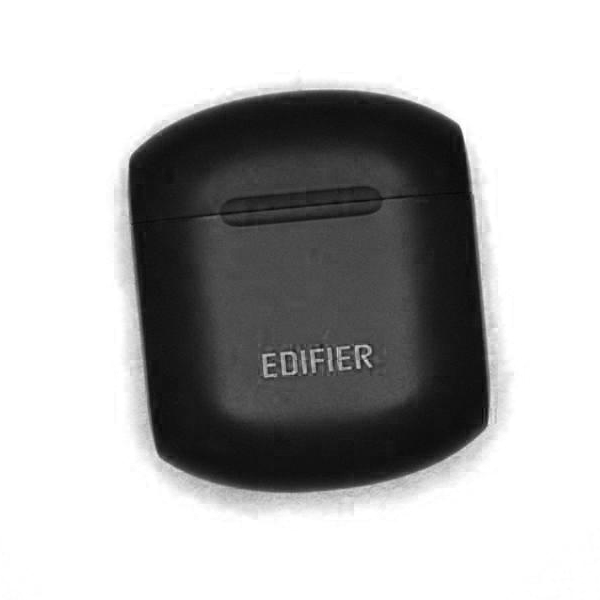

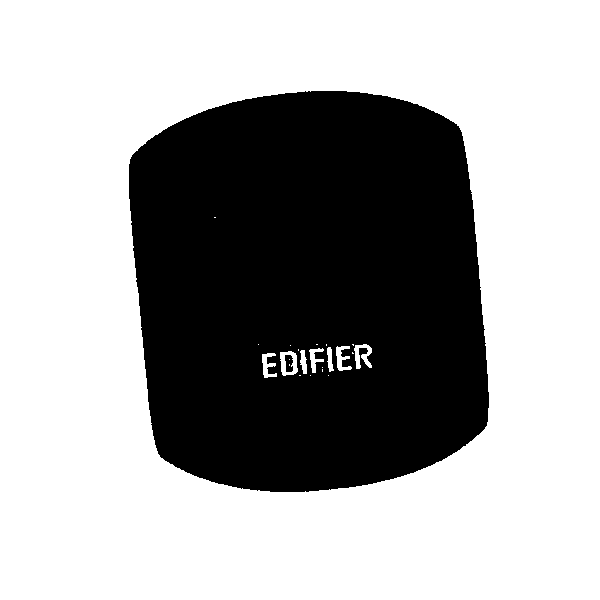

In [7]:
# Thresholding
threshold = 98

# Split image intensity into 3 colours
red, green, blue = cropped_img.split()  
display(red)   
display(green) 
display(blue)  # Pixel values of blue channel is higher compared to the red and green channels (Blue is dominant in original image)

threshold_img = blue.point(lambda p: p > threshold and 255) # Thresholding 
# Red and Blue will have higher contrast after thresholding because the blue-dominant areas 
# They will fall below the threshold, making the difference between light and dark regions more pronounced.
display(threshold_img) 




## Image Segmentation Using Thresholding


### Self-Define Function for Erosion and Dilation

In [8]:
def erode(cycles, image):
    for _ in range(cycles):
        image = image.filter(ImageFilter.MinFilter(3))
    return image

def dilate(cycles, image):
    for _ in range(cycles):
        image = image.filter(ImageFilter.MaxFilter(3))
    return image

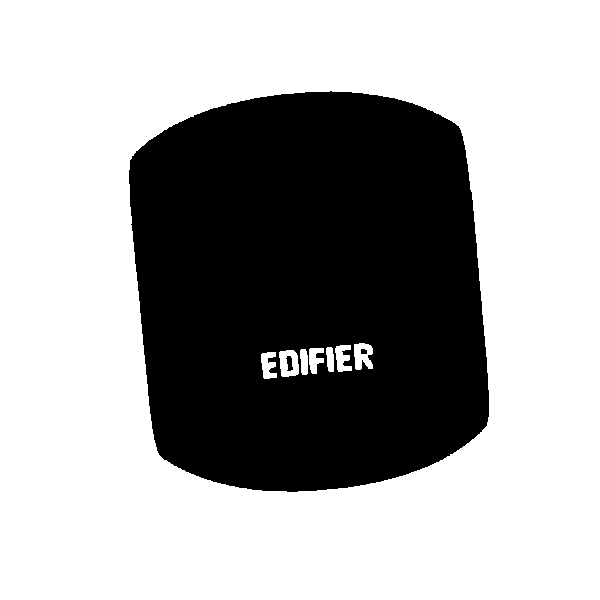

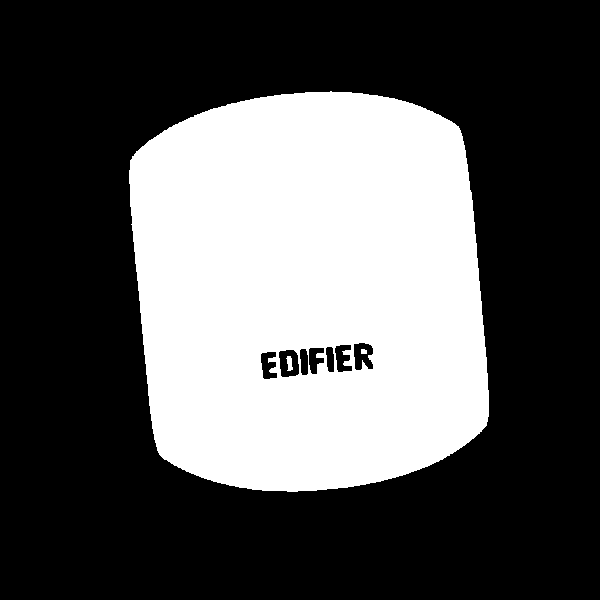

In [9]:
threshold = 98
red, green, blue = cropped_img.split()  
threshold_img = green.point(lambda p: p > threshold and 255) # Thresholding 

# Opening Process
threshold_img = erode(2, threshold_img)
threshold_img = dilate(2, threshold_img)

display(threshold_img)

# Invert image 
inverted_img = ImageOps.invert(threshold_img)
display(inverted_img)

### Applying Mask

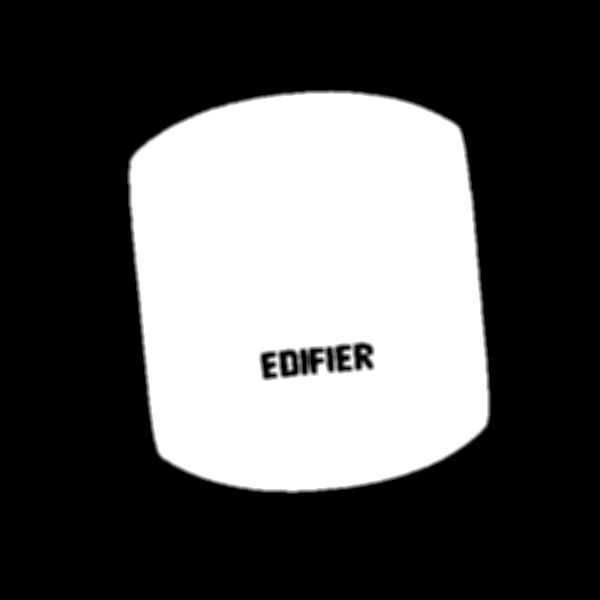

In [10]:
masked_img = inverted_img.convert("L")
masked_img  = inverted_img.filter(ImageFilter.BoxBlur(2))
display(masked_img)

### Extract Image

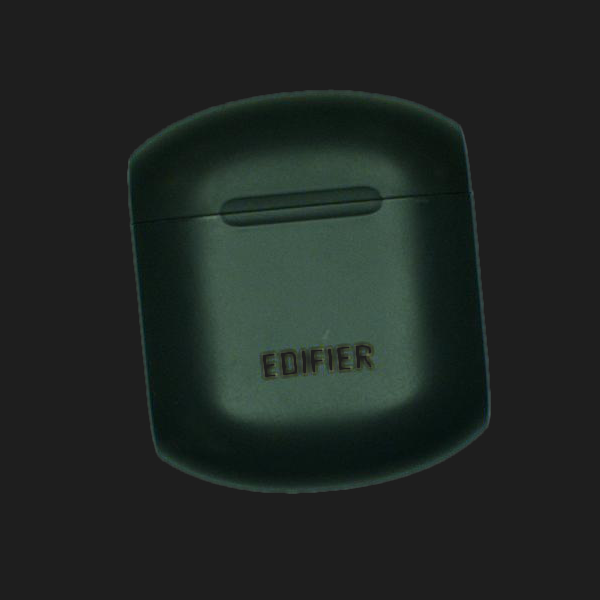

In [11]:
blank = cropped_img.point(lambda _: 30)
segmented_img = Image.composite(cropped_img, blank, masked_img)
display(segmented_img)

## Gradient-Based: Sobel Operator

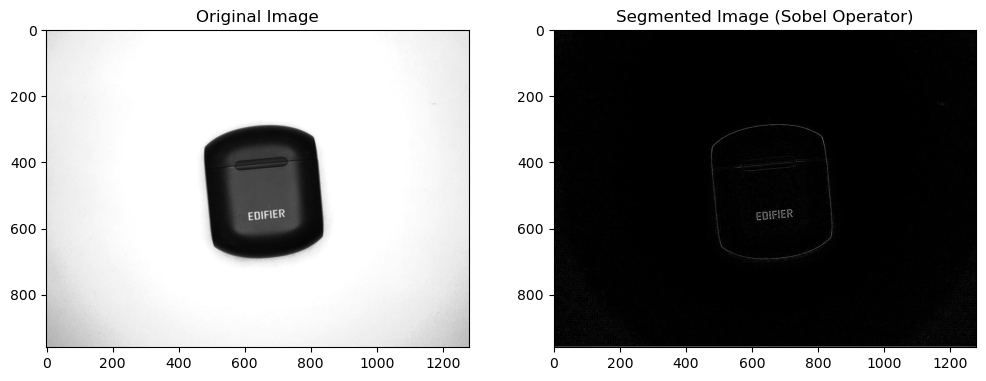

In [12]:
# Load the image and convert to grayscale
filename = 'D:\\UTAR\\Degree\\Y3S1\Machine Vision\\Practical\\Machine_Vision_Github\\Lab 2_Assets\\Earphone.jpg'

img = Image.open(filename).convert("L")

# Apply Sobel operator in the horizontal direction (X) and vertical direction (Y)
sobel_x = img.filter(ImageFilter.FIND_EDGES)  # Alternatively, can use a custom kernel for Sobel
sobel_y = img.filter(ImageFilter.FIND_EDGES)  # Alternatively, can use a custom kernel for Sobel

# Convert the PIL image to a NumPy array
sobel_x_array = np.array(sobel_x)
sobel_y_array = np.array(sobel_y)

# Combine the Sobel X and Y gradients to get the overall gradient magnitude
gradient_magnitude = np.hypot(sobel_x_array, sobel_y_array)
gradient_magnitude = gradient_magnitude / gradient_magnitude.max() * 255  # Normalize to range [0, 255]

# Convert back to a PIL image
gradient_img = Image.fromarray(gradient_magnitude.astype(np.uint8))

# Display the original and segmented images
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.title("Original Image")
plt.imshow(img, cmap='gray')

plt.subplot(1, 2, 2)
plt.title("Segmented Image (Sobel Operator)")
plt.imshow(gradient_img, cmap='gray')

## Region Segmentation: K-Mean Clustering 

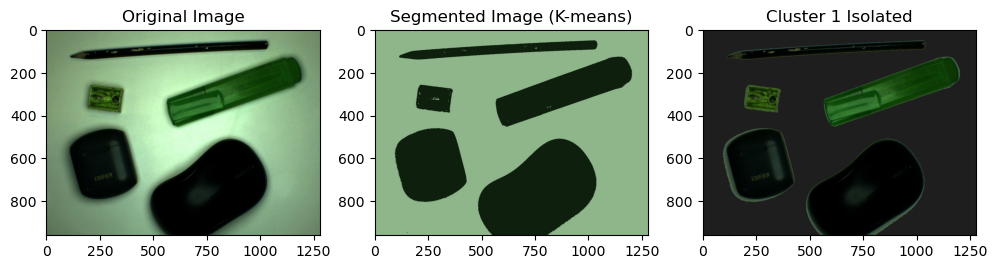

In [24]:
# Load the image
filename = 'D:\\UTAR\\Degree\\Y3S1\Machine Vision\\Practical\\Machine_Vision_Github\\Lab 2_Assets\\Best_Mix.jpg'  
img = cv2.imread(filename)
img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB) 


# Reshape the image to a 2D array of pixels
pixel_values = img_rgb.reshape((-1, 3))
pixel_values = np.float32(pixel_values)

# Define criteria for K-means (number of iterations and accuracy)
criteria = (cv2.TERM_CRITERIA_EPS + cv2.TERM_CRITERIA_MAX_ITER, 100, 0.2)

# Number of clusters (K)
k = 2 # You can adjust this number based on your image and desired segmentation

# Apply K-means clustering
_, labels, centers = cv2.kmeans(pixel_values, k, None, criteria, 10, cv2.KMEANS_RANDOM_CENTERS)

# Convert the centers to uint8 (color values)
centers = np.uint8(centers)

# Map the labels to the corresponding cluster center colors
segmented_image = centers[labels.flatten()]

# Reshape the segmented image back to the original image shape
segmented_image = segmented_image.reshape(img_rgb.shape)


# Optionally, mask the segmented image to isolate one or more clusters
masked_image = np.copy(img_rgb)
masked_image = masked_image.reshape((-1, 3))
cluster_number = 1  # Choose which cluster to mask (e.g., 0, 1, 2, etc.)
masked_image[labels.flatten() != cluster_number] = [30, 30, 30]  # Set non-cluster pixels to black
masked_image = masked_image.reshape(img_rgb.shape)

# Display the original and segmented images
plt.figure(figsize=(12, 6))
plt.subplot(1, 3, 1)
plt.title("Original Image")
plt.imshow(img_rgb)

plt.subplot(1, 3, 2)
plt.title("Segmented Image (K-means)")
plt.imshow(segmented_image)

plt.subplot(1, 3, 3)
plt.title(f"Cluster {cluster_number} Isolated")
plt.imshow(masked_image)

plt.show()


## Region Segmentation: Graph Cuts (Single Objects)

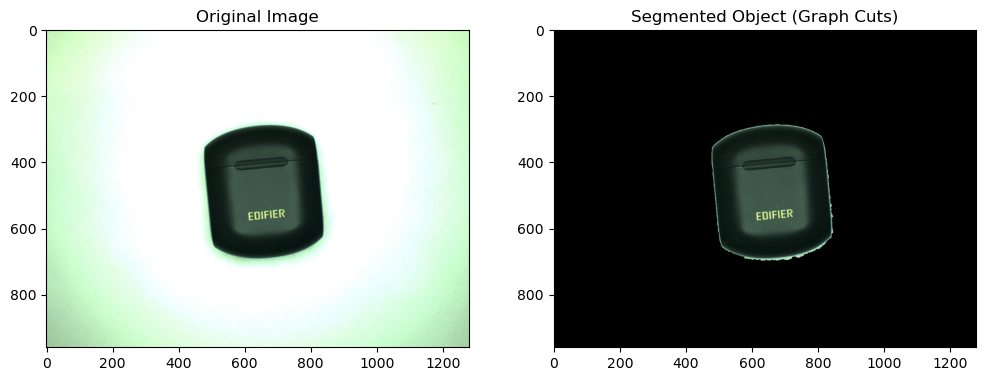

In [29]:
# Load the image of Single Object
filename = 'D:\\UTAR\\Degree\\Y3S1\\Machine Vision\\Practical\\Machine_Vision_Github\\Lab 2_Assets\\Earphone.jpg'  
img = cv2.imread(filename)
img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

# Create a mask where 0=background, 1=foreground
mask = np.zeros(img.shape[:2], np.uint8)

# Define background and foreground models (these are just placeholders)
bgdModel = np.zeros((1, 65), np.float64)
fgdModel = np.zeros((1, 65), np.float64)

# Define a rectangle around the area to be segmented (adjust these values based on your image)
rect = (70, 70, img.shape[1] - 400, img.shape[0] - 300)  # (x, y, width, height)


# Apply the grabCut algorithm
cv2.grabCut(img, mask, rect, bgdModel, fgdModel, 5, cv2.GC_INIT_WITH_RECT)

# Modify the mask such that pixels marked as probable background/foreground are assigned as background/foreground
mask2 = np.where((mask == 2) | (mask == 0), 0, 1).astype('uint8')

# Multiply the original image with the new mask to get the segmented image
segmented_image = img_rgb * mask2[:, :, np.newaxis]

# Display the original and segmented images
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.title("Original Image")
plt.imshow(img_rgb)

plt.subplot(1, 2, 2)
plt.title("Segmented Object (Graph Cuts)")
plt.imshow(segmented_image)

plt.show()

## Region Segmentation: Graph Cuts (Multiple Objects)

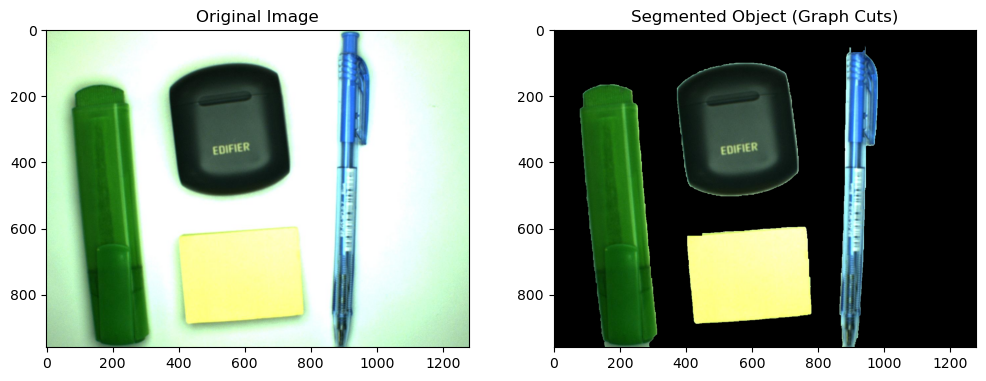

In [15]:
# Step 1: Load the image of Multiple Objects
image = cv2.imread('D:\\UTAR\\Degree\\Y3S1\\Machine Vision\\Practical\\Machine_Vision_Github\\Lab 2_Assets\\Mix_3.jpg')
image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)  # Convert to RGB for display

# Step 2: Initialize mask, background model, and foreground model
mask = np.zeros(image.shape[:2], np.uint8)
bgdModel = np.zeros((1, 65), np.float64)
fgdModel = np.zeros((1, 65), np.float64)

# Step 3: Define a rectangle around the foreground object
rect = (50, 50, image.shape[1] - 50, image.shape[0] - 50)  # Adjust based on your image

# Step 4: Apply the grabCut algorithm
cv2.grabCut(image, mask, rect, bgdModel, fgdModel, 5, cv2.GC_INIT_WITH_RECT)

# Step 5: Modify the mask such that pixels marked as probable background/foreground are assigned as background/foreground
mask2 = np.where((mask == 2) | (mask == 0), 0, 1).astype('uint8')

# Step 6: Multiply the original image with the new mask to get the segmented image
segmented_object = image_rgb * mask2[:, :, np.newaxis]

# Display the results
plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
plt.title('Original Image')
plt.imshow(image_rgb)

plt.subplot(1, 2, 2)
plt.title('Segmented Object (Graph Cuts)')
plt.imshow(segmented_object)

plt.show()

## Region Segmentation: Canny Edge Detection

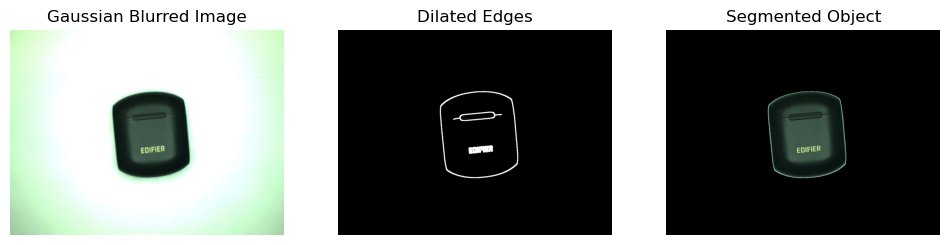

In [16]:
# Step 1: Load the image
image_bgr = cv2.imread('D:\\UTAR\\Degree\\Y3S1\\Machine Vision\\Practical\\Machine_Vision_Github\\Lab 2_Assets\\Earphone.jpg'  , cv2.IMREAD_COLOR)  # Load image in BGR
image_rgb = cv2.cvtColor(image_bgr, cv2.COLOR_BGR2RGB)
image = cv2.cvtColor(image_rgb, cv2.COLOR_RGB2GRAY)

# Dilation to remove noise
dilated_image = cv2.dilate(image, (5,5), iterations=2)
dilated_image_rgb = cv2.dilate(image_rgb, (5,5), iterations=2)

# Step 2: Apply Gaussian Filtering
blurred_image = cv2.GaussianBlur(dilated_image, (5, 5), 1.4)
blurred_image_rgb = cv2.GaussianBlur(dilated_image_rgb, (5, 5), 1.4)

# Step 3: Perform Edge Detection using Canny Edge Detector
edges = cv2.Canny(blurred_image, 40, 95)

# Step 4: Dilate the edges to make them thicker
kernel = np.ones((5, 5), np.uint8)
dilated_edges = cv2.dilate(edges, kernel, iterations=1)

# Step 5: Fill the object using flood fill or by finding contours
filled_mask = np.zeros_like(image)
contours, _ = cv2.findContours(dilated_edges, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

# Fill each contour
cv2.drawContours(filled_mask, contours, -1, (255), thickness=cv2.FILLED)

# Step 6: Apply the mask to the original image to isolate the object
segmented_image = np.zeros_like(image_rgb)
segmented_image[filled_mask == 255] = image_rgb[filled_mask == 255]
# segmented_image_rgb = cv2.cvtColor(segmented_image, cv2.COLOR_GRAY2RGB)


# Display the results
fig, ax = plt.subplots(1, 3, figsize=(12, 6))
# ax[0].imshow(image, cmap='gray')
# ax[0].set_title('Original Image')

ax[0].imshow(blurred_image_rgb)
ax[0].set_title('Gaussian Blurred Image')

# ax[2].imshow(edges, cmap='gray')
# ax[2].set_title('Edges Detected')

ax[1].imshow(dilated_edges, cmap='gray')
ax[1].set_title('Dilated Edges')

ax[2].imshow(segmented_image)
ax[2].set_title('Segmented Object')

for a in ax:
    a.axis('off')

plt.show()

# # ---------------------------------------------------------------------

# # Display the results
# plt.figure(figsize=(12, 6))

# plt.subplot(1, 2, 1)
# plt.title('Gaussian Blurred Image')
# plt.imshow(blurred_image_rgb)
# plt.axis('off')

# plt.subplot(1, 2, 2)
# plt.title('Dilated Edges')
# plt.imshow(dilated_edges, cmap='gray')
# plt.axis('off')

# plt.subplot(1, 2, 2)
# plt.title('Segmented Object (Canny Edge Detection)')
# plt.imshow(segmented_image)
# plt.axis('off')

# plt.tight_layout()
# plt.show()
# # ---------------------------------------------------------------------


## Region Segmentation: Testing Area 

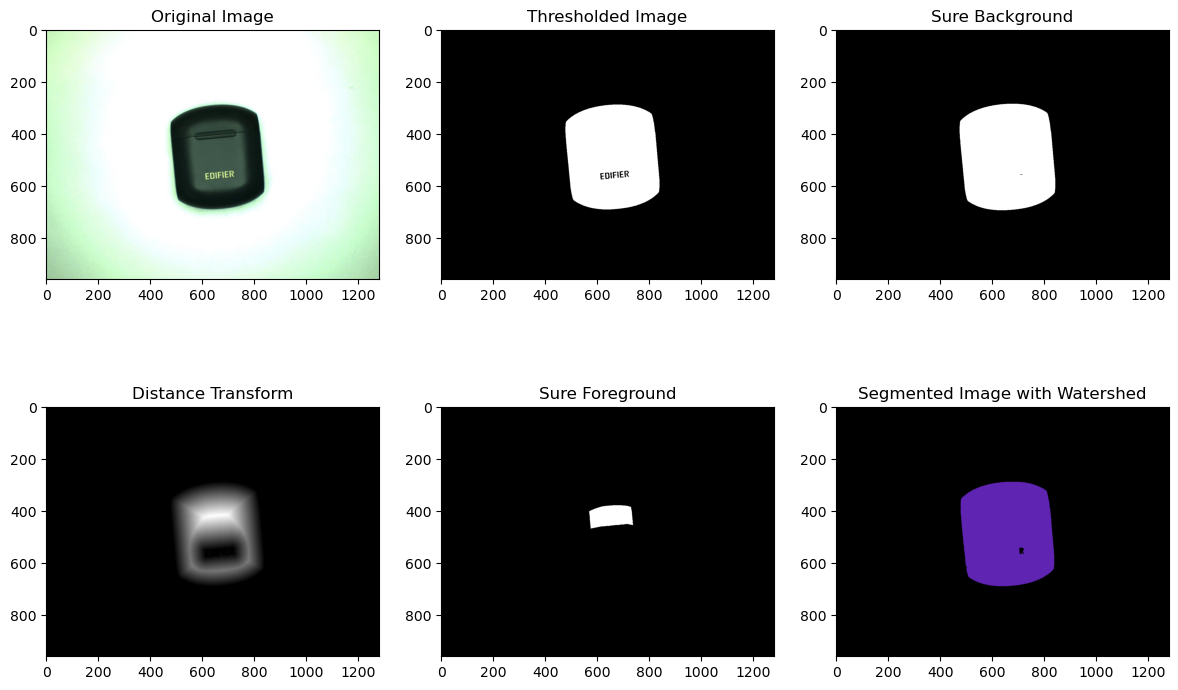

In [17]:
import cv2
import numpy as np
from matplotlib import pyplot as plt

# Load the image
filename = 'D:\\UTAR\\Degree\\Y3S1\\Machine Vision\\Practical\\Machine_Vision_Github\\Lab 2_Assets\\Earphone.jpg'
img = cv2.imread(filename)
img_gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

# Step 1: Apply thresholding to create a binary image
ret, thresh = cv2.threshold(img_gray, 0, 255, cv2.THRESH_BINARY_INV + cv2.THRESH_OTSU)

# Step 2: Remove small white noise through morphological opening
kernel = np.ones((3, 3), np.uint8)
opening = cv2.morphologyEx(thresh, cv2.MORPH_OPEN, kernel, iterations=2)

# Step 3: Determine sure background area by dilating the image
sure_bg = cv2.dilate(opening, kernel, iterations=3)

# Step 4: Determine sure foreground area using distance transform
dist_transform = cv2.distanceTransform(opening, cv2.DIST_L2, 5)
ret, sure_fg = cv2.threshold(dist_transform, 0.7 * dist_transform.max(), 255, 0)

# Step 5: Determine unknown region by subtracting sure_fg from sure_bg
sure_fg = np.uint8(sure_fg)
unknown = cv2.subtract(sure_bg, sure_fg)

# Step 6: Label the markers
ret, markers = cv2.connectedComponents(sure_fg)

# Add 1 to all labels to ensure the background is labeled as 1
markers = markers + 1

# Mark the unknown region with zero
markers[unknown == 255] = 0

# Step 7: Apply the Watershed algorithm
markers = cv2.watershed(img, markers)

# Create an output image with black background
segmented_img = np.zeros_like(img)

# Assign unique colors to each segmented region
for marker in range(2, np.max(markers) + 1):
    segmented_img[markers == marker] = np.random.randint(0, 255, size=3)

# Display the results
plt.figure(figsize=(12, 8))

plt.subplot(2, 3, 1)
plt.title("Original Image")
plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))

plt.subplot(2, 3, 2)
plt.title("Thresholded Image")
plt.imshow(thresh, cmap='gray')

plt.subplot(2, 3, 3)
plt.title("Sure Background")
plt.imshow(sure_bg, cmap='gray')

plt.subplot(2, 3, 4)
plt.title("Distance Transform")
plt.imshow(dist_transform, cmap='gray')

plt.subplot(2, 3, 5)
plt.title("Sure Foreground")
plt.imshow(sure_fg, cmap='gray')

plt.subplot(2, 3, 6)
plt.title("Segmented Image with Watershed")
plt.imshow(cv2.cvtColor(segmented_img, cv2.COLOR_BGR2RGB))

plt.tight_layout()
plt.show()